In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In this script we generate figure 5 in the main script. For each dataset we estimate Deviance Information Criterion for models with and without inflation parameters. Then we plot the difference between DIC values to demonstrate that the data support inflation. 

In [ ]:
from IPython import display
import pandas as pd
import numpy as np
import scipy
import scipy.stats

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tensorflow import keras

from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import pickle
from timeit import default_timer as timer

In [ ]:
tfd = tfp.distributions
tfb = tfp.bijectors
Folder = '/content/drive/MyDrive/'

In [ ]:
#Load parameters and data for mEBC data.
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_cor_atac_dic.pickle', 'rb') as handle:
    cor_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_m_acc_atac_dic.pickle', 'rb') as handle:
    m_acc_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_m_exp_atac_dic.pickle', 'rb') as handle:
    m_exp_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_s_acc_atac_dic.pickle', 'rb') as handle:
    s_acc_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_s_exp_atac_dic.pickle', 'rb') as handle:
    s_exp_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_inf_exp_atac_dic.pickle', 'rb') as handle:
    inf_exp_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_inf_acc_atac_dic.pickle', 'rb') as handle:
    inf_acc_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_llk_atac_dic.pickle', 'rb') as handle:
    llk_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_x_acc_mn_avg_dic.pickle', 'rb') as handle:
    x_acc_mn = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_x_exp_mn_avg_dic.pickle', 'rb') as handle:
    x_exp_mn = pickle.load(handle)

with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_cor_atac_ninf_dic.pickle', 'rb') as handle:
    cor_ninf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_m_acc_atac_ninf_dic.pickle', 'rb') as handle:
    m_acc_ninf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_m_exp_atac_ninf_dic.pickle', 'rb') as handle:
    m_exp_ninf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_s_acc_atac_ninf_dic.pickle', 'rb') as handle:
    s_acc_ninf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_s_exp_atac_ninf_dic.pickle', 'rb') as handle:
    s_exp_ninf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_llk_atac_ninf_dic.pickle', 'rb') as handle:
    llk_ninf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_atac_DIC_col/nuts_x_acc_mn_avg_ninf_dic.pickle', 'rb') as handle:
    x_acc_ninf_mn = pickle.load(handle)
with open(Folder+'CRaPL/Real/Results_atac_DIC_col/nuts_x_exp_mn_avg_ninf_dic.pickle', 'rb') as handle:
    x_exp_ninf_mn = pickle.load(handle)

yy_acc_pd = pd.read_csv(Folder+'SCRaPL/Real/Data/Acc_atac.csv',',',header=[0],index_col=[0])
yy_exp_pd = pd.read_csv(Folder+'SCRaPL/Real/Data/Rna_atac.csv',',',header=[0],index_col=[0])
Norm = pd.read_csv(Folder+'SCRaPL/Real/Data/Nrm_atac.csv',',',index_col=[1])
Norm = Norm.drop(columns=Norm.columns[0])

yy_acc = tf.convert_to_tensor(yy_acc_pd,dtype=tf.float32)
yy_exp = tf.convert_to_tensor(yy_exp_pd,dtype=tf.float32)
Norm_acc = tf.convert_to_tensor(Norm.iloc[:,0],dtype=tf.float32)
Norm_exp = tf.convert_to_tensor(Norm.iloc[:,1],dtype=tf.float32)

In [ ]:
aff = tfb.Chain([tfb.Shift(-1.),tfb.Scale(scale=2.)])
aff_inv = tfb.Invert(aff)

exp = tfb.Exp()
log = tfb.Invert(exp)

tanh = tfb.Tanh()
tanh_inv = tfb.Invert(tanh)

sigm = tfb.Sigmoid()
sigm_inv = tfb.Invert(sigm)

cor_trsf = tfb.Chain([aff_inv,tanh,tfb.Scale(scale=0.5)])
cor_trsf_inv = tfb.Invert(cor_trsf)

eps=0.001
bin_bij = tfb.Chain([tfb.Shift(eps/2.0),tfb.Scale(scale=1.0-eps),tfb.NormalCDF()])

cor_bij = tfb.Chain([tanh,tfb.Scale(scale=0.5)])
std_bij = tfb.Chain([exp,tfb.Scale(scale=-1.0)])
sqr_bij = tfb.Square()

In [ ]:
#SCRaPL's graphical model with and without inlfation for mEBC data.
def SCRaPL_atac_inf_dic(N_genes,N_cells,Nrm_acc,Nrm_rna,param):

    cor_lt,m_acc_lt,m_exp_lt,s_acc_lt,s_exp_lt,infl_acc_lt,infl_rna_lt = param

    def prior():

        Root = tfd.JointDistributionCoroutine.Root
        cor = cor_bij.forward(cor_lt)
        s_acc = std_bij.forward(s_acc_lt)
        s_exp = std_bij.forward(s_exp_lt)
        infl_acc = sigm.forward(infl_acc_lt)
        infl_rna = sigm.forward(infl_rna_lt)
        
        mm_acc = tf.math.multiply( m_acc_lt,tf.ones([N_genes,N_cells]))
        mm_exp = tf.math.multiply( m_exp_lt,tf.ones([N_genes,N_cells]))
        ss_acc = tf.math.multiply( s_acc   ,tf.ones([N_genes,N_cells]))
        ss_exp = tf.math.multiply( s_exp   ,tf.ones([N_genes,N_cells]))
        ccor =   tf.math.multiply( cor     ,tf.ones([N_genes,N_cells]))
        p_acc =  tf.math.multiply( infl_acc,tf.ones([N_genes,N_cells]))
        p_rna =  tf.math.multiply( infl_rna,tf.ones([N_genes,N_cells]))  

        nrm_acc = tf.math.multiply( log.forward(Nrm_acc),tf.ones([N_genes,1]))
        nrm_rna = tf.math.multiply( log.forward(Nrm_rna),tf.ones([N_genes,1]))

        x_acc = yield Root(tfd.Independent(tfd.Normal(loc = mm_acc, scale = ss_acc,name="x_acc") ,reinterpreted_batch_ndims=1))
        m_cnd_exp = mm_exp+tf.math.multiply(tf.math.divide(tf.math.multiply(ss_exp,x_acc-mm_acc),ss_acc),ccor)
        s_cnd_exp = tf.math.sqrt(tf.math.multiply(1-tf.math.square(ccor),tf.math.square(ss_exp)))

        x_exp = yield Root(tfd.Independent(tfd.Normal(loc = m_cnd_exp, scale = s_cnd_exp,name="x_exp"),reinterpreted_batch_ndims=1))

        pp_acc = tf.stack([p_acc,1-p_acc],axis=-1)
        x_acc_lt = tf.stack([-20*tf.ones_like(x_acc),x_acc+nrm_acc],axis=-1)

        pp_rna = tf.stack([p_rna,1-p_rna],axis=-1)
        x_exp_lt = tf.stack([-20*tf.ones_like(x_exp),x_exp+nrm_rna],axis=-1)

        y_acc = yield Root(tfd.Independent(tfd.MixtureSameFamily(
                                                          mixture_distribution = tfd.Categorical(probs=pp_acc),
                                                          components_distribution = tfd.Poisson(log_rate=x_acc_lt),
                                                          name="y_acc")
                            ,reinterpreted_batch_ndims=1))

        y_exp = yield Root(tfd.Independent(tfd.MixtureSameFamily(
                                                          mixture_distribution = tfd.Categorical(probs=pp_rna),
                                                          components_distribution = tfd.Poisson(log_rate=x_exp_lt),
                                                          name="y_exp")
                            ,reinterpreted_batch_ndims=1))

    comp_var_coroutine = tfd.JointDistributionCoroutine(prior)
    return comp_var_coroutine

def SCRaPL_atac_ninf_dic(N_genes,N_cells,Nrm_acc,Nrm_rna,param):

    cor_lt,m_acc_lt,m_exp_lt,s_acc_lt,s_exp_lt = param

    def prior():

        Root = tfd.JointDistributionCoroutine.Root
        cor = cor_bij.forward(cor_lt)
        s_acc = std_bij.forward(s_acc_lt)
        s_exp = std_bij.forward(s_exp_lt)
        
        mm_acc = tf.math.multiply( m_acc_lt,tf.ones([N_genes,N_cells]))
        mm_exp = tf.math.multiply( m_exp_lt,tf.ones([N_genes,N_cells]))
        ss_acc = tf.math.multiply( s_acc   ,tf.ones([N_genes,N_cells]))
        ss_exp = tf.math.multiply( s_exp   ,tf.ones([N_genes,N_cells]))
        ccor =   tf.math.multiply( cor     ,tf.ones([N_genes,N_cells]))

        nrm_acc = tf.math.multiply( log.forward(Nrm_acc),tf.ones([N_genes,1]))
        nrm_rna = tf.math.multiply( log.forward(Nrm_rna),tf.ones([N_genes,1]))

        x_acc = yield Root(tfd.Independent(tfd.Normal(loc = mm_acc, scale = ss_acc,name="x_acc") ,reinterpreted_batch_ndims=1))
        m_cnd_exp = mm_exp+tf.math.multiply(tf.math.divide(tf.math.multiply(ss_exp,x_acc-mm_acc),ss_acc),ccor)
        s_cnd_exp = tf.math.sqrt(tf.math.multiply(1-tf.math.square(ccor),tf.math.square(ss_exp)))

        x_exp = yield Root(tfd.Independent(tfd.Normal(loc = m_cnd_exp, scale = s_cnd_exp,name="x_exp"),reinterpreted_batch_ndims=1))


        y_acc = yield Root(tfd.Independent( tfd.Poisson(log_rate=nrm_acc+x_acc, name="y_acc") ,reinterpreted_batch_ndims=1))
        y_exp = yield Root(tfd.Independent( tfd.Poisson(log_rate=nrm_acc+x_exp, name="y_exp") ,reinterpreted_batch_ndims=1))

    comp_var_coroutine = tfd.JointDistributionCoroutine(prior)
    return comp_var_coroutine 

In [ ]:
#Esimate DIC for respective models in mEBC data.
batch_num = tf.shape(yy_acc)[0]
x_cells = tf.shape(yy_acc)[1]

cor_mn = tf.reduce_mean(cor_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
m_acc_mn = tf.reduce_mean(m_acc_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
m_exp_mn = tf.reduce_mean(m_exp_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
s_acc_mn = tf.reduce_mean(s_acc_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
s_exp_mn = tf.reduce_mean(s_exp_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
inf_acc_mn = tf.reduce_mean(inf_acc_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
inf_exp_mn = tf.reduce_mean(inf_exp_nuts,axis=0)[tf.newaxis,:,tf.newaxis]

x_acc_mn_lg = x_acc_mn[tf.newaxis,:,:]
x_exp_mn_lg = x_exp_mn[tf.newaxis,:,:]

y_acc = yy_acc[tf.newaxis,:,:]
y_exp = yy_exp[tf.newaxis,:,:]

cor_ninf_mn = tf.reduce_mean(cor_ninf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
m_acc_ninf_mn = tf.reduce_mean(m_acc_ninf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
m_exp_ninf_mn = tf.reduce_mean(m_exp_ninf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
s_acc_ninf_mn = tf.reduce_mean(s_acc_ninf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
s_exp_ninf_mn = tf.reduce_mean(s_exp_ninf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]

x_acc_mn_ninf_lg = x_acc_ninf_mn[tf.newaxis,:,:]
x_exp_mn_ninf_lg = x_exp_ninf_mn[tf.newaxis,:,:]

mdl_atac_inf_tr = SCRaPL_atac_inf_dic(batch_num,x_cells,Norm_acc,Norm_exp,[cor_mn,m_acc_mn,m_exp_mn,s_acc_mn,s_exp_mn,inf_acc_mn,inf_exp_mn])
mdl_atac_ninf_tr = SCRaPL_atac_ninf_dic(batch_num,x_cells,Norm_acc,Norm_exp,[cor_ninf_mn,m_acc_ninf_mn,m_exp_ninf_mn,s_acc_ninf_mn,s_exp_ninf_mn])

lg_atac_inf = mdl_atac_inf_tr.log_prob(x_acc_mn_lg,x_exp_mn_lg,y_acc,y_exp)
lg_atac_ninf = mdl_atac_ninf_tr.log_prob(x_acc_mn_ninf_lg,x_exp_mn_ninf_lg,y_acc,y_exp)

p_DIC_atac_inf = 2*(lg_atac_inf-tf.reduce_mean(llk_nuts,axis=0))
DIC_atac_inf = -2*lg_atac_inf+2*p_DIC_atac_inf

p_DIC_ninf = 2*(lg_atac_ninf-tf.reduce_mean(llk_ninf_nuts,axis=0))
DIC_atac_ninf = -2*lg_atac_ninf+2*p_DIC_ninf

DIC_atac_diff = (DIC_atac_inf-DIC_atac_ninf)
DIC_atac_diff_n = DIC_atac_diff[DIC_atac_diff<120000]

In [ ]:
#Load parameters and data for mESC data.
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_cor_gastr_dic.pickle', 'rb') as handle:
    cor_inf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_m_met_gastr_dic.pickle', 'rb') as handle:
    m_met_inf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_m_exp_gastr_dic.pickle', 'rb') as handle:
    m_exp_inf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_s_met_gastr_dic.pickle', 'rb') as handle:
    s_met_inf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_s_exp_gastr_dic.pickle', 'rb') as handle:
    s_exp_inf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_inf_gastr_dic.pickle', 'rb') as handle:
    inf_inf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_llk_gastr_dic.pickle', 'rb') as handle:
    llk_inf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_x_met_mn_avg_dic.pickle', 'rb') as handle:
    x_met_inf_mn = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_x_exp_mn_avg_dic.pickle', 'rb') as handle:
    x_exp_inf_mn = pickle.load(handle)

with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_cor_gastr_ninf_dic.pickle', 'rb') as handle:
    cor_ninf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_m_met_gastr_ninf_dic.pickle', 'rb') as handle:
    m_met_ninf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_m_exp_gastr_ninf_dic.pickle', 'rb') as handle:
    m_exp_ninf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_s_met_gastr_ninf_dic.pickle', 'rb') as handle:
    s_met_ninf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_s_exp_gastr_ninf_dic.pickle', 'rb') as handle:
    s_exp_ninf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_llk_gastr_ninf_dic.pickle', 'rb') as handle:
    llk_ninf_nuts = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_x_met_mn_avg_ninf_dic.pickle', 'rb') as handle:
    x_met_ninf_mn = pickle.load(handle)
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_x_exp_mn_avg_ninf_dic.pickle', 'rb') as handle:
    x_exp_ninf_mn = pickle.load(handle)

yy_met = pd.read_csv(Folder+'SCRaPL/Real/Data/Met.csv',sep=',',index_col=[0])
yy_exp = pd.read_csv(Folder+'SCRaPL/Real/Data/Rna.csv',sep=',',index_col=[0])
CpG = pd.read_csv(Folder+'SCRaPL/Real/Data/CpG.csv',sep=',',index_col=[0])
nrm = pd.read_csv(Folder+'SCRaPL/Real/Data/nrm.csv',sep=',',index_col=[1])

cl_nms = yy_met.columns
ft_nms = yy_met.index

Norm = tf.transpose(tf.convert_to_tensor(nrm,dtype=tf.float32))
yy_met = tf.convert_to_tensor(yy_met,dtype=tf.float32)
CpG = tf.convert_to_tensor(CpG,dtype=tf.float32)
yy_exp = tf.convert_to_tensor(yy_exp,dtype=tf.float32)

In [ ]:
#SCRaPL's graphical model with and without inlfation for mESC data.
def SCRaPL_gastr_inf_dic(N_genes,N_cells,Cover,Nrm,param):
    cor_lt,m_met_lt,m_exp_lt,s_met_lt,s_exp_lt,infl_lt = param
    def prior():
        Root = tfd.JointDistributionCoroutine.Root
        cor = cor_bij.forward(cor_lt)
        s_met = std_bij.forward(s_met_lt)
        s_exp = std_bij.forward(s_exp_lt)
        infl = sigm.forward(infl_lt)
        
        mm_met = tf.math.multiply( m_met_lt,tf.ones([1,N_genes,N_cells]))
        mm_exp = tf.math.multiply( m_exp_lt,tf.ones([1,N_genes,N_cells]))
        ss_met = tf.math.multiply( s_met   ,tf.ones([1,N_genes,N_cells]))
        ss_exp = tf.math.multiply( s_exp   ,tf.ones([1,N_genes,N_cells]))
        ccor =   tf.math.multiply( cor     ,tf.ones([1,N_genes,N_cells]))
        p =      tf.math.multiply( infl    ,tf.ones([1,N_genes,N_cells]))  
        nrm = tf.math.multiply( log.forward(Nrm),tf.ones([1,N_genes,1]))

        x_met = yield Root(tfd.Independent(tfd.Normal(loc = mm_met, scale = ss_met,name="x_met"),reinterpreted_batch_ndims=1))
        m_cnd_exp = mm_exp+tf.math.multiply(tf.math.divide(tf.math.multiply(ss_exp,x_met-mm_met),ss_met),ccor)
        s_cnd_exp = tf.math.sqrt(tf.math.multiply(1-tf.math.square(ccor),tf.math.square(ss_exp)))

        x_exp = yield Root(tfd.Independent(tfd.Normal(loc = m_cnd_exp, scale = s_cnd_exp,name="x_exp"),reinterpreted_batch_ndims=1))

        rt_bin = bin_bij.forward(x_met)

        pp = tf.stack([p,1-p],axis=-1)
        x_exp_msk= tf.where(tf.equal(Cover, 0), -20*tf.ones_like(x_exp),x_exp)
        x_exp_lt = tf.stack([-20*tf.ones_like(x_exp),x_exp_msk+nrm],axis=-1)

        y_met = yield Root(tfd.Independent(tfd.Binomial(total_count=Cover,probs=rt_bin,name="y_met"),reinterpreted_batch_ndims=1))
        y_exp = yield Root(
                            tfd.Independent(
                            tfd.MixtureSameFamily(
                                            mixture_distribution = tfd.Categorical(probs=pp),
                                            components_distribution = tfd.Poisson(log_rate=x_exp_lt),
                                            name="y_exp")
                            , reinterpreted_batch_ndims=1)
                            )

    comp_var_coroutine = tfd.JointDistributionCoroutine(prior)
    return comp_var_coroutine

def SCRaPL_gastr_ninf_dic(N_genes,N_cells,Cover,Nrm,param):
    cor_lt,m_met_lt,m_exp_lt,s_met_lt,s_exp_lt = param
    def prior():
        Root = tfd.JointDistributionCoroutine.Root
        cor = cor_bij.forward(cor_lt)
        s_met = std_bij.forward(s_met_lt)
        s_exp = std_bij.forward(s_exp_lt)
        
        mm_met = tf.math.multiply( m_met_lt,tf.ones([1,N_genes,N_cells]))
        mm_exp = tf.math.multiply( m_exp_lt,tf.ones([1,N_genes,N_cells]))
        ss_met = tf.math.multiply( s_met   ,tf.ones([1,N_genes,N_cells]))
        ss_exp = tf.math.multiply( s_exp   ,tf.ones([1,N_genes,N_cells]))
        ccor =   tf.math.multiply( cor     ,tf.ones([1,N_genes,N_cells]))
        nrm = tf.math.multiply( log.forward(Nrm),tf.ones([1,N_genes,1]))

        x_met = yield Root(tfd.Independent(tfd.Normal(loc = mm_met, scale = ss_met,name="x_met"),reinterpreted_batch_ndims=1))
        m_cnd_exp = mm_exp+tf.math.multiply(tf.math.divide(tf.math.multiply(ss_exp,x_met-mm_met),ss_met),ccor)
        s_cnd_exp = tf.math.sqrt(tf.math.multiply(1-tf.math.square(ccor),tf.math.square(ss_exp)))

        x_exp = yield Root(tfd.Independent(tfd.Normal(loc = m_cnd_exp, scale = s_cnd_exp,name="x_exp"),reinterpreted_batch_ndims=1))

        rt_bin = bin_bij.forward(x_met)

        y_met = yield Root(tfd.Independent(tfd.Binomial(total_count=Cover,probs=rt_bin,name="y_met"),reinterpreted_batch_ndims=1))
        y_exp = yield Root(tfd.Independent(tfd.Poisson(log_rate=x_exp+nrm, name="y_exp")   , reinterpreted_batch_ndims=1) )

    comp_var_coroutine = tfd.JointDistributionCoroutine(prior)
    return comp_var_coroutine

In [ ]:
#Esimate DIC for respective models in mESC data.
batch_num = tf.shape(CpG)[0]
x_cells = tf.shape(CpG)[1]

cor_inf_mn = tf.reduce_mean(cor_inf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
m_met_inf_mn = tf.reduce_mean(m_met_inf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
m_exp_inf_mn = tf.reduce_mean(m_exp_inf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
s_met_inf_mn = tf.reduce_mean(s_met_inf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
s_exp_inf_mn = tf.reduce_mean(s_exp_inf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
inf_inf_mn = tf.reduce_mean(inf_inf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]

x_met_inf_mn_lg = x_met_inf_mn[tf.newaxis,:,:]
x_exp_inf_mn_lg = x_exp_inf_mn[tf.newaxis,:,:]

cor_ninf_mn = tf.reduce_mean(cor_inf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
m_met_ninf_mn = tf.reduce_mean(m_met_ninf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
m_exp_ninf_mn = tf.reduce_mean(m_exp_ninf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
s_met_ninf_mn = tf.reduce_mean(s_met_ninf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]
s_exp_ninf_mn = tf.reduce_mean(s_exp_ninf_nuts,axis=0)[tf.newaxis,:,tf.newaxis]

x_met_ninf_mn_lg = x_met_ninf_mn[tf.newaxis,:,:]
x_exp_ninf_mn_lg = x_exp_ninf_mn[tf.newaxis,:,:]

y_met = yy_met[tf.newaxis,:,:]
y_exp = yy_exp[tf.newaxis,:,:]

mdl_gastr_tr_inf = SCRaPL_gastr_inf_dic(batch_num,x_cells,CpG,Norm,[cor_inf_mn,m_met_inf_mn,m_exp_inf_mn,s_met_inf_mn,s_exp_inf_mn,inf_inf_mn])
mdl_gastr_tr_ninf = SCRaPL_gastr_ninf_dic(batch_num,x_cells,CpG,Norm,[cor_ninf_mn,m_met_ninf_mn,m_exp_ninf_mn,s_met_ninf_mn,s_exp_ninf_mn])

lg_gastr_inf = mdl_gastr_tr_inf.log_prob(x_met_inf_mn_lg,x_exp_inf_mn_lg,y_met,y_exp)
lg_gastr_ninf = mdl_gastr_tr_ninf.log_prob(x_met_ninf_mn_lg,x_exp_ninf_mn_lg,y_met,y_exp)

p_DIC_gastr_inf = 2*(lg_gastr_inf-tf.reduce_mean(llk_inf_nuts,axis=0))
DIC_gastr_inf = -2*lg_gastr_inf+2*p_DIC_gastr_inf

p_DIC_gastr_ninf = 2*(lg_gastr_ninf-tf.reduce_mean(llk_ninf_nuts,axis=0))
DIC_gastr_ninf = -2*lg_gastr_ninf+2*p_DIC_gastr_ninf

DIC_gastr_dff = DIC_gastr_inf-DIC_gastr_ninf

In [ ]:
print(DIC_atac_diff_n)
print(DIC_atac_diff)
print(DIC_gastr_dff)

tf.Tensor([-5634.758  -3256.3672 -4390.9023 ... -4234.551  -8132.7695 -6074.0156], shape=(4232,), dtype=float32)
tf.Tensor([[-5634.758  -3256.3672 -4390.9023 ... -4234.551  -8132.7695 -6074.0156]], shape=(1, 4249), dtype=float32)
tf.Tensor([[-2265.603  -1428.5557 -1170.5933 ... -2091.5527 -2439.874  -1206.1768]], shape=(1, 9480), dtype=float32)


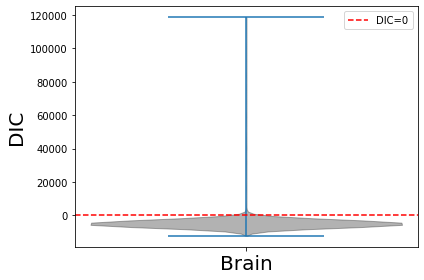

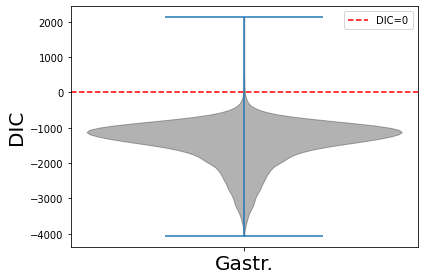

In [ ]:
#Plot DIC difference for mESC and mEBC data
_,ax = plt.subplots(nrows=1,ncols=1)
violin_parts = ax.violinplot(tf.squeeze(DIC_atac_diff_n),widths = 0.8)
ax.set_xticks([1])
ax.set_xticklabels(['Brain'],fontsize=20)
ax.axhline(y=0,color='red', linestyle='--',label='DIC=0')
plt.legend()
ax.set_ylabel('DIC',fontsize=20) 

for pc in violin_parts['bodies']:
    pc.set_facecolor('black')
    pc.set_edgecolor('black')
plt.tight_layout()
plt.savefig(Folder+'SCRaPL/Real/DIC_atac.pdf')
plt.show()

_,ax = plt.subplots(nrows=1,ncols=1)
violin_parts = ax.violinplot(DIC_gastr_dff,widths = 0.8)
ax.set_xticks([1])
ax.set_xticklabels(['Gastr.'],fontsize=20)
ax.axhline(y=0,color='red', linestyle='--',label='DIC=0')
plt.legend()
ax.set_ylabel('DIC',fontsize=20) 

for pc in violin_parts['bodies']:
    pc.set_facecolor('black')
    pc.set_edgecolor('black')
plt.tight_layout()
plt.savefig(Folder+'SCRaPL/Real/DIC_gastr.pdf')
plt.show()